In [40]:
import zipfile
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


zip_path = '/content/num+plate.zip'
extract_to = 'dataset'


os.makedirs(extract_to, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}/")


Extracted /content/num+plate.zip to dataset/


In [25]:
aug = "aug_data"
os.makedirs(aug, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [28]:
extract_to = "dataset"
num_plate_folder = os.path.join(extract_to, "num plate")

for class_folder in os.listdir(num_plate_folder):
    class_path = os.path.join(num_plate_folder, class_folder)
    aug_class_path = os.path.join(aug, class_folder)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)


        for img_name in images:
            try:
                shutil.copy(os.path.join(class_path, img_name), os.path.join(aug_class_path, img_name))
            except:
                continue


        aug_count = 0
        img_cycle = iter(images)

        while aug_count < 100:
            try:
                img_name = next(img_cycle)
            except StopIteration:
                img_cycle = iter(images)
                img_name = next(img_cycle)

            try:
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).convert("RGB").resize((256, 256))
                img_array = np.expand_dims(np.array(img), 0)
                aug_iter = datagen.flow(img_array, batch_size=1)
                aug_img = next(aug_iter)[0].astype(np.uint8)
                aug_pil = Image.fromarray(aug_img)
                aug_pil.save(os.path.join(aug_class_path, f"{img_name.split('.')[0]}_extra{aug_count}.jpg"))
                aug_count += 1
            except:
                continue

In [30]:
train_dir = "processed/train"
test_dir = "processed/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_folder in os.listdir(aug):
    class_path = os.path.join(aug, class_folder)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if len(images) == 0:
            print(f"No images found for class {class_folder}. Skipping...")
            continue

        train_imgs, test_imgs = train_test_split(images, test_size=0.05, random_state=42)

        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_folder, img))
        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_folder, img))


In [31]:
def preprocess_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        save_path = os.path.join(output_dir, class_folder)
        os.makedirs(save_path, exist_ok=True)
        for img_file in os.listdir(class_path):
            try:
                img = Image.open(os.path.join(class_path, img_file)).convert("L")
                img = img.resize((128, 128))
                img.save(os.path.join(save_path, img_file))
            except:
                pass

preprocess_and_save(train_dir, "final/train")
preprocess_and_save(test_dir, "final/test")


if not os.listdir(train_dir):
    print("train_dir is empty. Please check if data was copied correctly.")
else:
    sample_class = os.listdir(train_dir)[0]
    sample_img_name = os.listdir(os.path.join(train_dir, sample_class))[0]

    original_img = Image.open(os.path.join(train_dir, sample_class, sample_img_name))
    processed_img = Image.open(os.path.join("final/train", sample_class, sample_img_name))




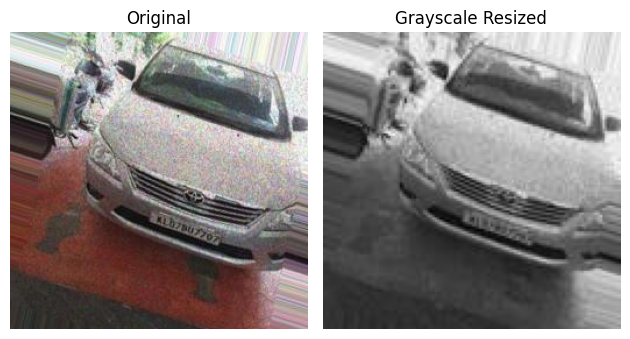

In [32]:
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Resized")
plt.imshow(processed_img, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

In [41]:
train_path = 'final/train'
test_path = 'final/test'


In [ ]:
final_path = "final"

for split in ["train", "test"]:
    split_path = os.path.join(final_path, split)
    total = 0
    print(f"\nIn '{split}' folder:")
    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            total += count
            print(f"  {class_folder}: {count} images")
    print(f"Total images in '{split}': {total}")


In [42]:


img_size = (128, 128)
batch_size = 35



In [43]:

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_data.class_indices)

Found 6794 images belonging to 35 classes.
Found 521 images belonging to 35 classes.


In [ ]:



model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_data,
    epochs=25,
    validation_data=test_data,
    callbacks=[checkpoint, early_stop]
)


model.load_weights("best_model.h5")
loss, accuracy = model.evaluate(test_data)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


model.save("final_model.h5")


Epoch 1/25
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0419 - loss: 3.5408

195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.0421 - loss: 3.5402 - val_accuracy: 0.0940 - val_loss: 3.3492
Epoch 2/25
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1140 - loss: 3.3145

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1142 - loss: 3.3138 - val_accuracy: 0.1958 - val_loss: 3.0230
Epoch 3/25
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1917 - loss: 2.9954

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1918 - loss: 2.9951 - val_accuracy: 0.3340 - val_loss: 2.5865
Epoch 4/25
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2967 - loss: 2.5965

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2967 - loss: 2.5960 - val_accuracy: 0.4837 - val_loss: 2.1177
Epoch 5/25
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3970 - loss: 2.1680

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3970 - loss: 2.1680 - val_accuracy: 0.5893 - val_loss: 1.7709
Epoch 6/25
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4780 - loss: 1.8116

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4779 - loss: 1.8117 - val_accuracy: 0.6411 - val_loss: 1.4751
Epoch 7/25
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5764 - loss: 1.4550

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5763 - loss: 1.4553 - val_accuracy: 0.7006 - val_loss: 1.2727
Epoch 8/25
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6289 - loss: 1.2693

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6288 - loss: 1.2695 - val_accuracy: 0.7447 - val_loss: 1.1633
Epoch 9/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6796 - loss: 1.0789 - val_accuracy: 0.7370 - val_loss: 1.1406
Epoch 10/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7214 - loss: 0.9295 - val_accuracy: 0.7332 - val_loss: 1.1384
Epoch 11/25
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7331 - loss: 0.8473

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7330 - loss: 0.8475 - val_accuracy: 0.7524 - val_loss: 1.1222
Epoch 12/25
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7675 - loss: 0.7766

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7674 - loss: 0.7768 - val_accuracy: 0.7812 - val_loss: 1.0862
Epoch 13/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7967 - loss: 0.6525 - val_accuracy: 0.7812 - val_loss: 1.0635
Epoch 14/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8232 - loss: 0.5852 - val_accuracy: 0.7620 - val_loss: 1.0953
Epoch 15/25
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8278 - loss: 0.5543

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8277 - loss: 0.5545 - val_accuracy: 0.7908 - val_loss: 1.0435
Epoch 16/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8333 - loss: 0.5350 - val_accuracy: 0.7735 - val_loss: 1.1815
Epoch 17/25
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8485 - loss: 0.4771

195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8484 - loss: 0.4774 - val_accuracy: 0.7946 - val_loss: 1.1399
Epoch 18/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8502 - loss: 0.4714 - val_accuracy: 0.7812 - val_loss: 1.0719
Epoch 19/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8530 - loss: 0.4530

195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8530 - loss: 0.4530 - val_accuracy: 0.8004 - val_loss: 1.0641
Epoch 20/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8763 - loss: 0.3969 - val_accuracy: 0.7812 - val_loss: 1.1502
Epoch 21/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8737 - loss: 0.3888 - val_accuracy: 0.7946 - val_loss: 1.1462
Epoch 22/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8916 - loss: 0.3443 - val_accuracy: 0.7889 - val_loss: 1.2450
Epoch 23/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8743 - loss: 0.3813 - val_accuracy: 0.7754 - val_loss: 1.2264
Epoch 24/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8868 - loss: 0.3496 - val_accuracy: 0.7850 - val_loss: 1.2814
Epoch 25/25
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8912 - loss: 0.3410 - val_accuracy: 0.7946 - val_loss: 1.3319
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8026 - loss: 1.0876



Test Accuracy: 80.04%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


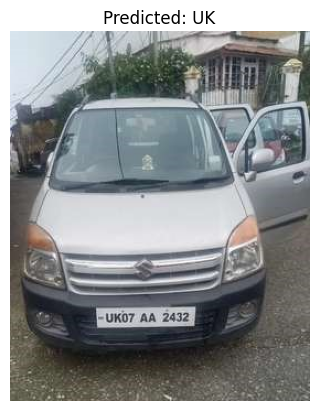

Predicted class: UK


In [ ]:
model = load_model("final_model.h5")

def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")  
    img = img.resize((128, 128))  
    img_array = np.array(img)  
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = np.expand_dims(img_array, axis=-1)  
    return img_array


img_path = '/content/shuffle_9.jpg'

img = preprocess_image(img_path)

prediction = model.predict(img)


predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())  
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


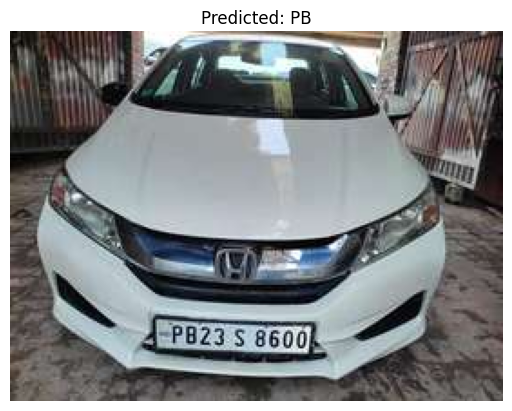

Predicted class: PB


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image


model = load_model("final_model.h5")


def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")  
    img = img.resize((128, 128))  
    img_array = np.array(img)  
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = np.expand_dims(img_array, axis=-1)  
    return img_array


img_path = '/content/shuffle_7.jpg'


img = preprocess_image(img_path)


prediction = model.predict(img)

predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())  
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")
